# Small conductance based network

In this project, we aim at simulating a small (two-neuron) network formed by identical conductance-
based neuron models, with the following structure:
- Neuron 1 receives a Poisson input at ν Hz through synapses modulated by an α function.
- Neuron 1 excites Neuron 2 through a graded synapsis.
- Neuron 2 inhibits Neuron 1 through a graded synapsis.

In the last part of the project, we will study the effect of plasticity (facilitation and depression).



**1-Simulate an input Poisson train for 1 second with rate $ν = 50Hz$**. 

For the homogeneous Poisson process we have $P\,[\text{ 1 spike during } \delta t]=r\delta t$ where $r$ is the input rate. This equation can be used to generate a Poisson  spike train $\{t_j\}_{j=1}^{n_{spk}}$ by first subdividing time into short intervals, each of duration $\delta t$. Then, generate a sequence of random numbers $x[i]$, uniformly distributed between 0 and 1. For each $\delta t$-interval, if $x[i] ≤ r∆t$, generate a spike. Otherwise, no spike is generated. This procedure is appropriate only when $\delta t$ is very small, i.e, only when $r\delta t$ << 1. Typically, ${\delta t}$ = 0.1 msec should suffice. 

For more information, see these notes by David Heeger (NYU).

In [4]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

Simple run

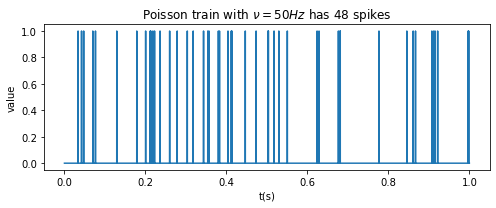

In [113]:
dt = 0.0001 # dt = 0.1msec
t = np.arange(0.0, 1.0, dt)
rate = 50

spikes = np.random.rand(len(t)) < rate*dt #Determine list of times of spikes
spikes = spikes.astype(int)

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(t, spikes)
ax.set(title=f"Poisson train with $ν = 50Hz$ has {np.sum(spikes)} spikes",
       xlabel="t(s)",
       ylabel="value")
fig.tight_layout()
fig.show()

Number of spikes histogram

In [164]:
dt = 0.0001 # dt = 0.1msec
t = np.arange(0.0, 1.0, dt)
rate = 50

n_runs = 10000
results = np.zeros(n_runs)
for i in range(n_runs):
    spikes = np.random.rand(len(t)) < rate*dt #Determine list of times of spikes
    spikes = spikes.astype(int)
    results[i] = np.sum(spikes)

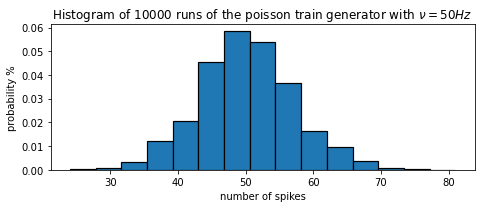

In [165]:
fig, ax = plt.subplots(figsize=(7,3))
ax.hist(results,15,density=True,edgecolor='black', linewidth=1.2)
ax.set(title=f"Histogram of {n_runs} runs of the poisson train generator with $ν = 50Hz$",
       xlabel="number of spikes",
       ylabel="probability %")
fig.tight_layout()
fig.show()

Time between spikes histogram

In [256]:
dt = 0.0001 # dt = 0.1 msec
t = np.arange(0.0, 1.0, dt)
rate = 50

n_runs = 100
intervals = []
for i in range(n_runs):
    spikes = np.random.rand(len(t)) < rate*dt #Determine list of times of spikes
    index = np.where(spikes)[0]
    intervals.append(index[1:]-index[:-1])
    
intervals = np.concatenate(intervals).ravel()

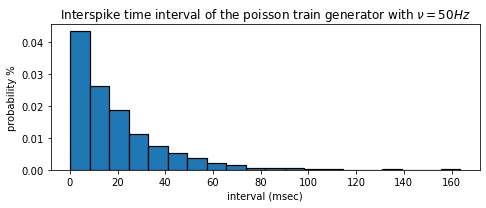

In [167]:
fig, ax = plt.subplots(figsize=(7,3))
ax.hist(intervals*0.1,20,density=True,edgecolor='black', linewidth=1.2)
ax.set(title=f"Interspike time interval of the poisson train generator with $ν = 50Hz$",
       xlabel="interval (msec)",
       ylabel="probability %")
fig.tight_layout()
fig.show()

In [339]:
def spike_train(d, rate, dt):
    """ Generates Poisson delta train
    Params:
    d (int): duration in second of the train
    rate (int): how many firings per second (Hz)
    dt (float): time differential used in the simulation
    Returns:
    result (np.array) with the indexes of the spikes
    """
    # As the standard dt is 1ms and this is not enough for this method to
    # give accurate results I add a reduction factor to spike generation
    reduction = 10   
    n = int(d/dt*reduction)
    spikes = np.random.rand(n) < rate*d*dt/reduction
    index = np.where(spikes)[0]
    return index/reduction

**2-Study of the post-synaptic potentials induced by the Poisson train.**

From the spike train obtained in (1), generate a synaptic input $g_{syn}(t) = \hat{g}\sum_j\alpha(t-t_j)H(t-t_j)$ where $\alpha (t) = 1/\tau_{s}^{2}t\text{exp}(-t/\tau_{s})$ and $H$ is the Heaviside function. Inject it into the system (you can try to inject the first only):

$$CV = I - g_L(V-E_L)-g_{Na}m_{\infty}(V)(V-E_{Na})-g_Kn(V-E_K)+g_{syn}(t)(V-E_{syn})$$
$$\tau_nn = n_{\infty}(V)-n$$

with
$$m_{\infty}(V) = 1./(1.+exp(-(V-V_{max,m})/k_m))$$
and
$$n_{\infty}(V) = 1./(1.+exp(-(V-V_{max,n})/k_n))$$

In [383]:
# global model variables
ena, gk, el, esyn = 60, -90, -80, -30
gna, gk, gl = 20, 10, 8 
C, I = 1, 0
vmaxm, vmaxn = -20, -25
km, kn = 15, 5
taun, taus = 1, 5 

Synaptic excitation function

In [330]:
def alfa(t):
    return 1/taus**2*t*np.e**(-t/taus)
def step(t):
    return 1 if t > 0 else 0
def gsyn(t, train):
    result = 0
    for it in train:
        result += alfa(t-it)*step(t-it)
    return result

Synaptic excitation run with simple input

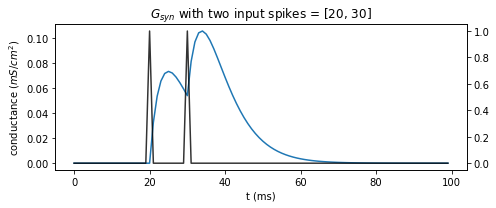

In [380]:
results = []
spikes = [20,30]
for i in range(100):
    results.append(gsyn(i, spikes))

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(res)

ax2 = ax.twinx()
spike_p = np.zeros(100)
spike_p[spikes] += 1
ax2.plot(spike_p,c='k',alpha=0.8,)

ax.set(title="$G_{syn}$ "+f"with two input spikes = {spikes}",
       xlabel="t (ms)",
       ylabel="conductance ($mS/cm^2$)")
fig.tight_layout()
fig.show()

Synaptic excitation run with complex input

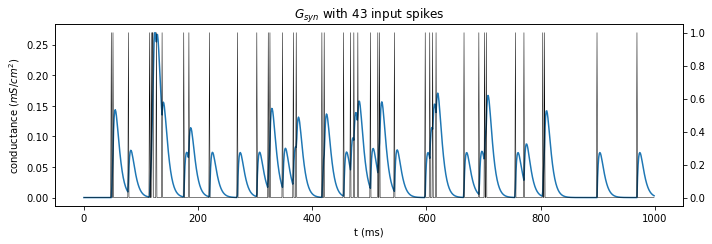

In [375]:
dt=0.001 # 1 ms
d = 1
spikes = spike_train(d, 50, dt)
results = []
for i in range(np.arange(0,d,dt).shape[0]):
    results.append(gsyn(i, spikes))

fig, ax = plt.subplots(figsize=(10,3.5))
ax.plot(results,lw=1.5)

ax2 = ax.twinx()
spike_p = np.zeros(int(d/dt))
spike_p[np.rint(spikes).astype(int)] += 1
ax2.plot(spike_p, c='k',alpha=1, lw=0.5)

ax.set(title="$G_{syn}$ "+f"with {spikes.shape[0]} input spikes",
       xlabel="t (ms)",
       ylabel="conductance ($mS/cm^2$)")
fig.tight_layout()
fig.show()

Neuron equations

In [382]:
def minf(V):
    return 1/(1+np.e**(-(V-vmaxm)/km))
def ninf(V):
    return 1/(1+np.e**(-(V-vmaxn)/kn))